# TF-IDF with N-Grams

## Data import

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np

In [2]:
amazon_df_train = pd.read_csv('data/dataset_amazon_train.csv')
amazon_df_test = pd.read_csv('data/dataset_amazon_test.csv')
pd.options.display.max_colwidth = 50

In [3]:
amazon_df_train.head(5)

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
amazon_df_train = pd.DataFrame(data=amazon_df_train, columns=['Score', 'Text'])
amazon_df_test = pd.DataFrame(data=amazon_df_test, columns=['Score', 'Text'])

In [5]:
amazon_df_train[40:43]

,Score,Text
40,5,The variety packs taste great!<br /><br />I ha...
41,5,McCann's makes oatmeal for every oatmeal conno...
42,5,I have McCann's Oatmeal every morning and by o...


## Define labels

In [6]:
y = np.array(amazon_df_train['Score'])

In [7]:
y_test = np.array(amazon_df_test['Score'])

## Clean Text

In [8]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [9]:
from tqdm import tqdm
def clean(text_list, lemmatize, stemmer):
    
    updates = []
    
    for j in tqdm(text_list):
        
        text = j
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)
        
        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        #Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        #Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [10]:
amazon_df_train['Cleaned_Text'] = clean(amazon_df_train['Text'], lemmatize = True, stemmer = False)

100%|██████████████████████████████████| 75000/75000 [00:06<00:00, 11455.63it/s]


In [11]:
amazon_df_test['Cleaned_Text'] = clean(amazon_df_test['Text'], lemmatize = True, stemmer = False)

100%|████████████████████████████████████| 5000/5000 [00:00<00:00, 11708.20it/s]


In [12]:
amazon_df_train.head()

,Score,Text,Cleaned_Text
0,5,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...
2,4,This is a confection that has been around a fe...,confection around century light pillowy citrus...
3,2,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,5,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


## TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

* 1-Gram

In [14]:
word_tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1, 1))
X_word = word_tfidf.fit_transform(amazon_df_train["Cleaned_Text"])

* N-Gram, N>1

In [15]:
ngram_tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1, 3))
X_ngram = ngram_tfidf.fit_transform(amazon_df_train["Cleaned_Text"])

## Train Classifier

In [16]:
from sklearn.neighbors import KNeighborsClassifier

* 1-Gram

In [17]:
modelknn_word = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

In [18]:
modelknn_word.fit(X_word,y)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

* N-Gram, N>1

In [19]:
modelknn_ngram = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

In [20]:
modelknn_ngram.fit(X_ngram,y)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

## Predict for Test corpus

In [21]:
labels = {"Very Bad":1, "Bad":2, "Neutral":3, "Good":4, "Very Good":5}

* 1-Gram

In [22]:
X_test_word = word_tfidf.transform(amazon_df_test["Cleaned_Text"])

In [23]:
y_pred_word = modelknn_word.predict(X_test_word)

In [24]:
from sklearn.metrics import classification_report

In [25]:
print(classification_report(y_pred_word, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

    Very Bad       0.24      0.53      0.33       212
         Bad       0.07      0.37      0.12        57
     Neutral       0.11      0.38      0.17        99
        Good       0.13      0.32      0.18       266
   Very Good       0.94      0.70      0.80      4366

    accuracy                           0.66      5000
   macro avg       0.30      0.46      0.32      5000
weighted avg       0.84      0.66      0.73      5000



In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred_word, y_test)

array([[ 112,   25,   24,   17,   34],
       [   9,   21,    7,    8,   12],
       [  10,    5,   38,   23,   23],
       [  27,   19,   22,   84,  114],
       [ 312,  213,  267,  535, 3039]])

<ipython-input-27-26e8100d02d5>:42: UserWarning: Attempting to set identical bottom == top == 4.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


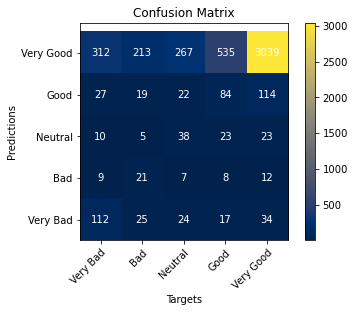

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

plot_cm(confusion_matrix(y_pred_word, y_test), labels.keys())

* N-Gram, N>1

In [28]:
X_test_ngram = ngram_tfidf.transform(amazon_df_test["Cleaned_Text"])

In [29]:
y_pred_ngram = modelknn_ngram.predict(X_test_ngram)

In [30]:
print(classification_report(y_pred_ngram, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

    Very Bad       0.25      0.58      0.35       201
         Bad       0.06      0.35      0.11        51
     Neutral       0.10      0.35      0.16       103
        Good       0.13      0.36      0.19       242
   Very Good       0.95      0.70      0.80      4403

    accuracy                           0.66      5000
   macro avg       0.30      0.47      0.32      5000
weighted avg       0.86      0.66      0.74      5000



In [31]:
confusion_matrix(y_pred_ngram, y_test)

array([[ 117,   27,   16,   10,   31],
       [  12,   18,    8,    5,    8],
       [  12,   10,   36,   16,   29],
       [  21,   23,   23,   86,   89],
       [ 308,  205,  275,  550, 3065]])

<ipython-input-32-4318d284a8a0>:39: UserWarning: Attempting to set identical bottom == top == 4.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


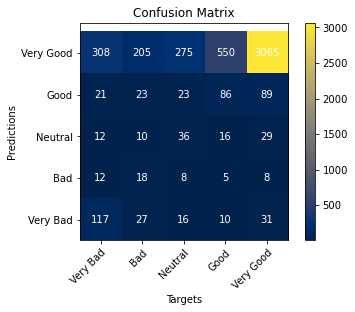

In [32]:
def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

plot_cm(confusion_matrix(y_pred_ngram, y_test), labels.keys())

# NB, LR and MLP

# 1. Data Import

In [33]:
df = pd.read_csv("Corona_NLP.csv", encoding='latin-1')
pd.options.display.max_colwidth = 500
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,"Due to COVID-19 our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March 16. We will continue to process online and phone orders as normal! Thank you for your understanding! https://t.co/kw91zJ5O5i",Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona",Negative


In [34]:
df  = df[['OriginalTweet', 'Sentiment']].head(10000)

In [35]:
set(df['Sentiment'].values)

{'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'}

In [36]:
df['LabelSentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ['Extremely Positive', 'Positive', 'Neutral'] else 0)

In [37]:
df.head()

,OriginalTweet,Sentiment,LabelSentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,1
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,1
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,1
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,1
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative,0


<AxesSubplot:>

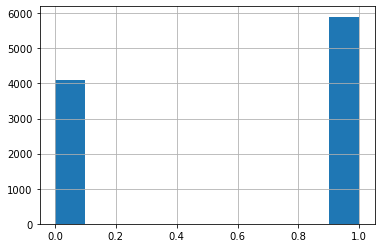

In [38]:
df['LabelSentiment'].hist()

# 2. Train - Test split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['LabelSentiment'], test_size=0.20, random_state=4)

In [40]:
len(X_train), len(X_test), len(y_train), len(y_test)

(8000, 2000, 8000, 2000)

# 3. Clean Text

In [41]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [42]:
from tqdm import tqdm
def clean(text_list):
    
    updates = []
    
    for j in tqdm(text_list):
        
        text = j
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        
        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        #Lemmatize
        text = " ".join(lemma.lemmatize(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [43]:
X_train_clean = clean(X_train)

100%|██████████| 8000/8000 [00:01<00:00, 6641.29it/s]


In [44]:
X_test_clean = clean(X_test)

100%|██████████| 2000/2000 [00:00<00:00, 5518.52it/s]


# 4. Feature Engineering

In [45]:
tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1,2))

### Train

In [46]:
X = tfidf.fit_transform(X_train_clean).toarray()

In [47]:
X.shape

(8000, 128412)

In [48]:
y = y_train.to_numpy()

In [49]:
y

array([1, 1, 1, ..., 0, 1, 1])

### Test

In [50]:
x_test = tfidf.transform(X_test_clean).toarray()

In [51]:
y_test = y_test.to_numpy()

# 5. Train Models and Evaluate

# Naive Bayes

In [52]:
from sklearn.naive_bayes import GaussianNB

In [53]:
nb = GaussianNB()

In [54]:
nb.fit(X, y)

GaussianNB()

### Predict

In [55]:
nb_pred = nb.predict(x_test)

In [56]:
from sklearn.metrics import classification_report

In [57]:
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.53      0.56      0.55       814
           1       0.69      0.66      0.67      1186

    accuracy                           0.62      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.63      0.62      0.62      2000



In [58]:
from sklearn.metrics import confusion_matrix
confusion_matrix(nb_pred, y_test)

array([[459, 402],
       [355, 784]])

The confusion matrix in sklearn is presented in the following format: <br>
    [ [ TN  FP  ] <br>
    [ FN  TP ] ]

### Attributes

* Check the probability of each class.

In [59]:
nb.class_prior_

array([0.4105, 0.5895])

* Verify the number of training samples observed in each class.

In [60]:
nb.class_count_

array([3284., 4716.])

# Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
LogisticRegression?

In [63]:
lr = LogisticRegression(random_state=0)

In [64]:
lr.fit(X,y)

LogisticRegression(random_state=0)

In [65]:
lr.classes_

array([0, 1])

In [66]:
lr.coef_

array([[-0.25726277, -0.08367722, -0.06491548, ...,  0.04307403,
         0.04307403,  0.03135067]])

In [67]:
lr.intercept_

array([0.36464732])

In [68]:
lr_pred = lr.predict(x_test)

In [69]:
lr_pred

array([1, 0, 1, ..., 1, 0, 1])

In [70]:
lr.predict_proba(x_test)

array([[0.32647214, 0.67352786],
       [0.79308787, 0.20691213],
       [0.17264834, 0.82735166],
       ...,
       [0.10759331, 0.89240669],
       [0.62431318, 0.37568682],
       [0.46898066, 0.53101934]])

In [71]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.81      0.54      0.65       814
           1       0.74      0.91      0.82      1186

    accuracy                           0.76      2000
   macro avg       0.77      0.72      0.73      2000
weighted avg       0.77      0.76      0.75      2000



In [72]:
confusion_matrix(lr_pred, y_test)

array([[ 437,  104],
       [ 377, 1082]])

# Multilayer Perceptron - ANN

__The number of hidden layers__<br>
-	Increasing the number of hidden layers might or might not improve the accuracy, it depends on the complexity of the problem
-	Increasing the number of hidden layers more than needed will cause overfit on the training set and a decrease in the accuracy value for the test set

__The number of hidden units__ <br>
-	Using too few neurons in the hidden layers will result in underfitting
-	Using too many neurons in the hidden layer may result in overfitting and increases the training time of the neural network

The aim is to keep a good trade-off between the simplicity of the model and the performance accuracy! <br>

__Different rules of thumb exist (take them with a grain of salt):__
-	_The number of hidden neurons should be between the size of the input layer and the size of the output layer_
-	_The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer_
-	_The number of hidden neurons should be less than twice the size of the input layer_



In [73]:
from sklearn.neural_network import MLPClassifier

In [74]:
MLPClassifier?

In [75]:
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=1)

In [76]:
mlp.fit(X,y)

/Users/ynesrodrigues/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(2, 2), random_state=1)

In [77]:
mlp_pred = mlp.predict(x_test)

In [78]:
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       0.78      0.64      0.70       814
           1       0.78      0.87      0.82      1186

    accuracy                           0.78      2000
   macro avg       0.78      0.76      0.76      2000
weighted avg       0.78      0.78      0.77      2000



In [79]:
confusion_matrix(mlp_pred, y_test)

array([[ 520,  150],
       [ 294, 1036]])

## Attributes

### Activation Function

In [80]:
model_relu = MLPClassifier(activation = 'relu')

- __Advantages:__
     - Computationally efficient - allows the network to converge very quickly.
- __Disadvantages:__
     - The dying ReLU problem - When inputs approach zero, or are negative, the gradient of the function becomes zero and the network cannot perform backpropagation and cannot learn.

In [81]:
model_logistic = MLPClassifier(activation = 'logistic')

 - __Advantages:__
     - Smooth gradient, preventing “jumps” in output values.
     - Output values bound between 0 and 1, normalizing the output of each neuron.
 - __Disadvantages:__
     - Vanishing gradient—for very high or very low values of X, there is almost no change to the prediction, causing a vanishing gradient problem. This can result in the network refusing to learn further, or have slow convergence.
     - Computationally expensive.

In [82]:
model_tanh = MLPClassifier(activation = 'tanh')

 - __Advantages:__
     - Zero centered - making it easier to model inputs that have strongly negative, neutral and strongly positive values. Other than that it is similar to the sigmoid function. <br>
 - __Disadvantages:__
     - Same as with the sigmoid function

### Solver

In [83]:
model_sgd = MLPClassifier(solver = 'sgd')

__Notes__
- While Gradient Descent use the whole training data to do a single update, in SGD a random data point of the training data to update the parameters - SGD is faster than GD.
- It uses a common learning rate for all parameters, contrarialy to what happens in Adam.

In [84]:
model_adam = MLPClassifier(solver = 'adam')

__When to use__ <br>
- It achieves good results fast - good for complex models, if processing time is an issue.

__Notes__ <br>
- It computes individual adaptive learning rates for different parameters
- Adam combines the advantages of RMSProp and AdaGrad <br>

## Other Parameters

|Parameter| Definition | LBFGS | SGD | ADAM |
|---|---|---|---|---|
|alpha| L2 penalty (regularization term) parameter | yes | yes | yes |
| power_t | The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to ‘invscaling’. | no | yes | no |
| shuffle | Whether to shuffle samples in each iteration. | no | yes | yes |
| tol | Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to ‘adaptive’, convergence is considered to be reached and training stops. | yes | yes | yes |
| warm_start | When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. | yes | yes | yes |
| momentum | Momentum for gradient descent update. Should be between 0 and 1. | no | yes | no |
| nesterovs_momentum | Whether to use Nesterov’s momentum.| no | yes | no |
| early stopping | Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting.  | no | yes | yes |
| validation_fraction | The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True | no | yes | yes|
| beta1 | Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). | no | no | yes |
| beta2 | Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1).  | no | no | yes |
| epsilon | Value for numerical stability in adam. | no | no | yes |
| n_iter_no_change | Maximum number of epochs to not meet tol improvement. |  no | yes | yes |
| max_fun | Only used when solver=’lbfgs’. Maximum number of loss function calls. The solver iterates until convergence (determined by ‘tol’), number of iterations reaches max_iter, or this number of loss function calls. | yes | no | no |

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1]
}

In [ ]:
model = MLPClassifier()

In [ ]:
clf = GridSearchCV(model, parameter_space)

In [ ]:
clf.fit(X, y)

In [ ]:
clf.best_params_

In [ ]:
final_model = clf.best_estimator_.fit(X, y)
print('Train:', final_model.score(X, y))
print('Test:', final_model.score(X_test, y_test))

In [ ]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

# Object-Orienting Programing
Before we start I would like to review/talk about some object-oriented programming concepts.
These concepts will be usefull to understand the following code and they are present everywhere when we use datascience toolkits such as the well-known sklearn.

<!--- https://www.techtarget.com/searchapparchitecture/definition/object-oriented-programming-OOP -->

The structure, or building blocks, of object-oriented programming include the following:

* `Classes` are user-defined data types that act as the blueprint for individual objects, attributes and methods.
* `Objects` are instances of a class created with specifically defined data. Objects can correspond to real-world objects or an abstract entity. When class is defined initially, the description is the only object that is defined.
* `Methods` are functions that are defined inside a class that describe the behaviors of an object. Each method contained in class definitions starts with a reference to an instance object. Additionally, the subroutines contained in an object are called instance methods. Programmers use methods for reusability or keeping functionality encapsulated inside one object at a time.
* `Attributes` are defined in the class template and represent the state of an object. Objects will have data stored in the attributes field. Class attributes belong to the class itself.

<img src="images/whatis-object_oriented_programming.png" alt="Alt text that describes the graphic" title="Title text" />

## Exercise:
Define a "dog" and "cat" classes with the following attributes:
- name (string)
- age  (integer)
- energy (integer initialized with the value 0)

And the following methods:
- eat: This method increments the energy level by 1.
- sleep: This method increments the energy level by 3.
- play: This method decrements the energy level by 5. If the object is a Cat this method should return the string "miau miau..." and, if the object is a Dog, this method should return "wauf wauf...."

Also, only for the Dog class, implement an extra method called "sit" that increments the energy level by 1.

In [85]:
class Animal():
    def __init__(self, name, age):
        self.name = name
        self.age = age
        self.energy = 0
    
    def eat(self):
        self.energy += 1
        
    def sleep(self):
        self.energy += 3
    
    def play(self):
        self.energy -= 5

class Dog(Animal):
    def __init__(self, name, age):
        super().__init__(name, age)
    
    def play(self):
        super().play()
        print ("wauf wauf")

class Cat(Animal):
    def __init__(self, name, age):
        super().__init__(name, age)
    
    def play(self):
        super().play()
        print ("miau miau")

In [86]:
dog_obj = Dog(name="gandalf", age=1)
cat_obj = Cat(name="python", age=1)

assert issubclass(type(dog_obj), Animal)
assert issubclass(type(cat_obj), Animal)
assert dog_obj.energy == 0
assert cat_obj.energy == 0

dog_obj.eat()
cat_obj.eat()
assert dog_obj.energy == 1
assert cat_obj.energy == 1

dog_obj.eat()
cat_obj.eat()
dog_obj.sleep()
cat_obj.sleep()
assert dog_obj.energy == 5
assert cat_obj.energy == 5

dog_obj.play()
cat_obj.play()
assert dog_obj.energy == 0
assert cat_obj.energy == 0

wauf wauf
miau miau


As you can observe the methods we defined change the internal state of the objects we have created without accessing to the energy attribute directly.

Also with this approach we can create lists of objects and call methods without knowing if those objects are dogs or cats.

In [87]:
animals = [Dog(name="gandalf", age=1), Cat(name="python", age=1)]

for animal in animals:
    animal.eat()

print (animals[0].energy)
print (animals[1].energy)

1
1


# Linear Classifiers

Now that we have seen the fundamental concepts behind Object-Oriented Programming we will implement from scratch a simple **Rosenblatt Perceptron** and a **Logistic Regression** classifier.


## Our Corpus:
In order to test our models we will use the "Twenty Newsgroups". Here is the official description, quoted from the [website](http://qwone.com/~jason/20Newsgroups/):

"_The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of our knowledge, it was originally collected by Ken Lang, probably for his paper “Newsweeder: Learning to filter netnews,” though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering._"

### Corpus Loading and Preprocessing:

For simplification we will only use 4 categories out of the 20 possible ones.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [89]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [90]:
len(twenty_train.data), len(twenty_train.filenames)

(2034, 2034)

In [91]:
twenty_train.data[0]

"From: rych@festival.ed.ac.uk (R Hawkes)\nSubject: 3DS: Where did all the texture rules go?\nLines: 21\n\nHi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych\n\n======================================================================\nRycharde Hawkes\t\t\t\temail: rych@festival.ed.ac.uk\nVirtual Environment Laboratory\nDept. of Psychology\t\t\tTel  : +44 31 650 3426\nUniv. of Edinburgh\t\t\tFax  : +44 31 667 0150\n==============

In [92]:
twenty_train.target[0]

1

### Feature Extraction:

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.8)
X = vectorizer.fit_transform(twenty_train.data).toarray()
Y = twenty_train.target
X.shape, Y.shape

((2034, 33811), (2034,))

Now that we have our data imported we can start working on our classifiers.

## Classifier Class:

Going back to our problem, the first thing to do is to define a common structure shared across the different Linear Classifiers. Note that they are similar in nature and for that reason they will have a lot in common.

Namely, both this algorithm share the following functions:
- **Train:** The train function receives a set of training features (X) and the corresponding labels (Y) and updates the model parameters over $n$ epochs.
- **Evaluate:** A function that computes the model accuracy with the current parameters.
- **plot_train:** A function to plot train/dev accuracy over epoch.
- **update_weights:** This is the function that is used to update the model weights.
- **predict:** Function used to make new predictions with the current model parameters.

The difference between the Logistic Regression and the Perceptron algorithm will lie in these last two functions and for that reason the classifier class does not implement them.


In [94]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np

class Classifier(object):
    """ Multi Class Classifier base class """

    def __init__(self, input_size, n_classes):
        """
        Initializes a matrix in which each column will be the Weights for a specific class.
        :param input_size: Number of features
        :param n_classes: Number of classes to classify the inputs
        """
        self.parameters = np.zeros((input_size+1, n_classes)) # input_size +1 to include the Bias term

    def train(self, X, Y, devX, devY, epochs=20):
        """
        This trains the perceptron over a certain number of epoch and records the
            accuracy in Train and Dev sets along each epoch.
        :param X: numpy array with size DxN where D is the number of training examples
                 and N is the number of features.
        :param Y: numpy array with size D containing the correct labels for the training set
        :param devX (optional): same as X but for the dev set.
        :param devY (optional): same as Y but for the dev set.
        :param epochs (optional): number of epochs to run.
        """
        train_accuracy = [self.evaluate(X, Y)]
        dev_accuracy = [self.evaluate(devX, devY)]
        for epoch in range(epochs):
            for i in tqdm(range(X.shape[0])):
                self.update_weights(X[i, :], Y[i])
            train_accuracy.append(self.evaluate(X, Y))
            dev_accuracy.append(self.evaluate(devX, devY))
        return train_accuracy, dev_accuracy
        

    def evaluate(self, X, Y):
        """
        Evaluates the error in a given set of examples.
        :param X: numpy array with size DxN where D is the number of examples to 
                    evaluate and N is the number of features.
        :param Y: numpy array with size D containing the correct labels for the training set
        """
        correct_predictions = 0
        for i in range(X.shape[0]):
            y_pred = self.predict(X[i, :])
            if Y[i] == y_pred:
                correct_predictions += 1
        return correct_predictions/X.shape[0]


    def plot_train(self, train_accuracy, dev_accuracy):
        """
        Function to Plot the accuracy of the Training set and Dev set per epoch.
        :param train_accuracy: list containing the accuracies of the train set.
        :param dev_accuracy: list containing the accuracies of the dev set.
        """
        x_axis = [epoch+1 for epoch in range(len(train_accuracy))]
        plt.plot(x_axis, train_accuracy, '-g', linewidth=1, label='Train')
        plt.xlabel("epochs")
        plt.ylabel("Accuracy")
        plt.plot(x_axis, dev_accuracy, 'b-', linewidth=1, label='Dev')
        plt.legend()
        plt.show()


    def update_weights(self, x, y):
        """
        Function that will take an input example and the true prediction and will 
            update the model parameters.
        
        :param x: Array of size N where N its the number of features that the model 
                  takes as input.
        :param y: The int corresponding to the correct label.
        
        child classes must implement this function
        """
        pass

    def predict(self, x):
        """
        This function will add a Bias value to the received input, multiply the Weights 
            corresponding to the different classeswith the input vector and choose the 
            class that maximizes that multiplication.
        
        :param x: numpy array with size 1xN where N = number of features.
        
        child classes must implement this function
        """
        pass

## Logistic Regression:
Since we have a multi-class classification problem we have to define a Multinomial Logistic Regression, which in other words is a Logistic Regression with a softmax function in the end.

<img src="images/multinomialLR.png" alt="Alt text that describes the graphic" title="Title text" />
<img src="images/mlr.webp" alt="Alt text that describes the graphic" title="Title text" />

When predicting with such model we want to compute:
<img src="images/LRargmax.png" alt="Alt text that describes the graphic" title="Title text" />

where $Z_x$ is defined as:

<img src="images/LRZx.png" alt="Alt text that describes the graphic" title="Title text" />

#### But how can we learn W ??

We want to find a set of parameters $\hat{W}$ that for our training samples  $D = \{x_t, y_t\}_{t=1}^N$ maximize the following probability:

<img src="images/LRobjective1.png" alt="Alt text that describes the graphic" title="Title text" />

which is equivalent to minimizing:

<img src="images/LRobjective2.png" alt="Alt text that describes the graphic" title="Title text" />

According to the **gradient descent algorithm** our model parameters are updated according to the following update rule:

<img src="images/GD.png" alt="Alt text that describes the graphic" title="Title text" />

In [95]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

class MultinomialLR(Classifier):
    """ Multinomial Logistic Regression """

    def __init__(self, input_size, n_classes, lr=0.001):
        """
        Initializes a matrix in which each column will be the Weights for a specific class.
        :param input_size: Number of features
        :param n_classes: Number of classes to classify the inputs
        """
        Classifier.__init__(self, input_size, n_classes)
        self.lr = lr

    def predict(self, input):
        """
        This function will add a Bias value to the received input, multiply the 
            Weights corresponding to the different classeswith the input vector, run 
            a softmax function and choose the class that achieves an higher probability.
        :param x: numpy array with size 1xN where N = number of features.
        """
        return np.argmax(self.softmax(np.dot(np.append(input, [1]), self.parameters)))

    def softmax(self, x):
        """ Compute softmax values for each sets of scores in x."""
        return np.exp(x-np.max(x))/np.sum(np.exp(x-np.max(x)), axis=0)

    def update_weights(self, x, y):
        """
        Function that will take an input example and the true prediction and will update
            the model parameters.
        :param x: Array of size N where N its the number of features that the model takes as input.
        :param y: The int corresponding to the correct label.
        """
        linear = np.dot(np.append(x, [1]), self.parameters)
        predictions = self.softmax(linear)
        self.parameters = self.parameters - self.lr*(np.outer(predictions, np.append(x, [1])).T)
        self.parameters[:, y] = self.parameters[:, y] + self.lr*np.append(x, [1])

In [96]:
lr = MultinomialLR(X.shape[1], len(np.unique(Y)))

In [97]:
lr.parameters.shape

(33812, 4)

Before training we will have to load the test set to validate if our accuracy improves over epoch.

In [98]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories)
X_test = vectorizer.transform(twenty_test.data).toarray()
Y_test = twenty_test.target
X_test.shape, Y_test.shape

((1353, 33811), (1353,))

In [99]:
train_acc, dev_acc = lr.train(X, Y, devX=X_test, devY=Y_test, epochs=5)

  0%|          | 0/2034 [00:00<?, ?it/s]

  0%|          | 0/2034 [00:00<?, ?it/s]

  0%|          | 0/2034 [00:00<?, ?it/s]

  0%|          | 0/2034 [00:00<?, ?it/s]

  0%|          | 0/2034 [00:00<?, ?it/s]

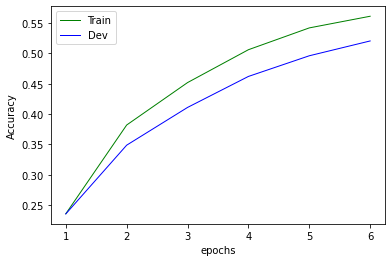

In [100]:
lr.plot_train(train_acc, dev_acc)

## Rosenblatt Perceptron:
Now that we have seen the logistic regression example (which is the hardest one), you will have to implement the Rosenblatt Perceptron.

Remember that the only thing that is different from this classifier to the Logistic Regression example is the update rule of the weights, that when the predicted label $\hat{y}$ is not correct $\hat{y} \neq y$ follows the following rule:

<img src="images/perceptronUpdateRule.png" alt="Alt text that describes the graphic" title="Title text" />

Which basically states that we have to add to the "correct" class parameters $W_y$ the input features $x$ and decrement to the incorrectly predicted class parameters $W_{\hat{y}}$ the input features $x$.


In terms of prediction the Rosenblatt preceptron follows the following expression:

<img src="images/perceptron_pred.png" alt="Alt text that describes the graphic" title="Title text" />

<!---
    def predict(self, x):
        return np.argmax(np.dot(np.append(x, [1]), self.parameters))

    def update_weights(self, x, y):
        y_pred = self.predict(x)
        if y != y_pred:
            self.parameters[:, y] += np.append(x, [1])
            self.parameters[:, y_pred] -=  np.append(x, [1])
-->


In [101]:
class MultiClassPerceptron(Classifier):
    """ Multi Class Perceptron """

    def __init__(self, input_size, n_classes):
        """
        Initializes a matrix in which each column will be the Weights for a specific class.
        :param input_size: Number of features
        :param n_classes: Number of classes to classify the inputs
        """
        Classifier.__init__(self, input_size, n_classes)

    def predict(self, x):
        """
        This function will add a Bias value to the received input, multiply the Weights 
            corresponding to the different classes with the input vector and choose the class 
            that maximizes that multiplication.
        :param x: numpy array with size 1xN where N = number of features.
        """
        return np.argmax(np.dot(np.append(x, [1]), self.parameters))


    def update_weights(self, x, y):
        """
        Function that will take an input example and the true prediction and will update the 
            model parameters.
        :param x: Array of size N where N its the number of features that the model takes as input.
        :param y: The int corresponding to the correct label.
        """
        y_pred = self.predict(x)
        if y != y_pred:
            self.parameters[:, y] += np.append(x, [1])
            self.parameters[:, y_pred] -=  np.append(x, [1])
        

In [102]:
perceptron = MultiClassPerceptron(X.shape[1], len(np.unique(Y)))

In [103]:
perceptron.parameters.shape

(33812, 4)

In [104]:
train_acc, dev_acc = perceptron.train(X, Y, devX=X_test, devY=Y_test, epochs=5)

  0%|          | 0/2034 [00:00<?, ?it/s]

  0%|          | 0/2034 [00:00<?, ?it/s]

  0%|          | 0/2034 [00:00<?, ?it/s]

  0%|          | 0/2034 [00:00<?, ?it/s]

  0%|          | 0/2034 [00:00<?, ?it/s]

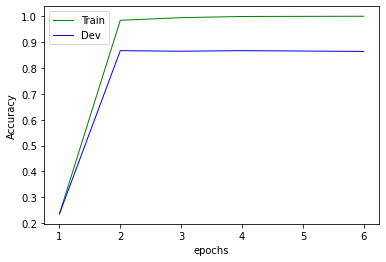

In [105]:
perceptron.plot_train(train_acc, dev_acc)